In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
%matplotlib inline
from sklearn import metrics
np.random.seed(1) # set a seed so that the results are consistent

In [2]:
#Define functions for Planer_Utils

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    X = X.T
    Y = Y.T

    return X, Y

def load_extra_datasets():  
    N = 200
    noisy_circles = sklearn.datasets.make_circles(n_samples=N, factor=.5, noise=.3)
    noisy_moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
    blobs = sklearn.datasets.make_blobs(n_samples=N, random_state=5, n_features=2, centers=6)
    gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)
    no_structure = np.random.rand(N, 2), np.random.rand(N, 2)

    return noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure

In [3]:
X, Y = load_planar_dataset()

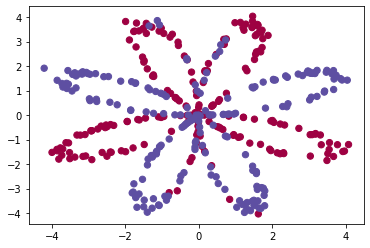

In [4]:
# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=Y[0], s=40, cmap=plt.cm.Spectral);

In [5]:
print(X.shape) # Shape of X
print(Y.shape) # Shape of Y
print(X.shape[1]) # Training samples

(2, 400)
(1, 400)
400


## Performing Logistic Regression

In [6]:
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y[0].T)

LogisticRegressionCV()

Accuracy is: 0.47


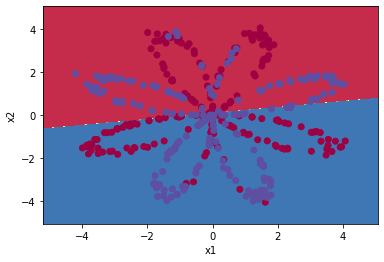

In [7]:
#plotting the decision boundary
plot_decision_boundary(lambda x: clf.predict(x), X, Y[0])
LR_pred = clf.predict(X.T)
accuracy =metrics.accuracy_score(Y[0],LR_pred)
print("Accuracy is:", accuracy)

## Neural Network Approach

In [8]:
#Defining the neural network structure
def layer_size(X,Y):
    n_x = X.shape[0] # size of input layer
    n_y = Y.shape[0] # size of output layer
    n_h = 4         # size of the hidden layer 
    return (n_x, n_h, n_y)

In [9]:
#Initialize the model's parameters
def initialize_parameters(n_x, n_h, n_y):
    W1 = np.random.randn(n_h,n_x) * 0.01
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(n_y,n_h) * 0.01
    b2 = np.zeros((n_y,1))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

In [10]:
#Implementing forward_propagation()
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    Z1 = np.dot(W1,X) +b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1)+b2
    A2 = sigmoid(Z2)
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    return A2, cache

In [11]:
#Implement compute_cost() to compute the value of the cost J
def compute_cost(A2, Y, parameters):
    m = Y.shape[1] #number of samples
    logprobs = np.dot(Y, np.log(A2.T)) + np.dot((1-Y), np.log(1 - A2).T)
    cost = -np.sum(logprobs) / m
    cost = float(np.squeeze(cost))
    return cost

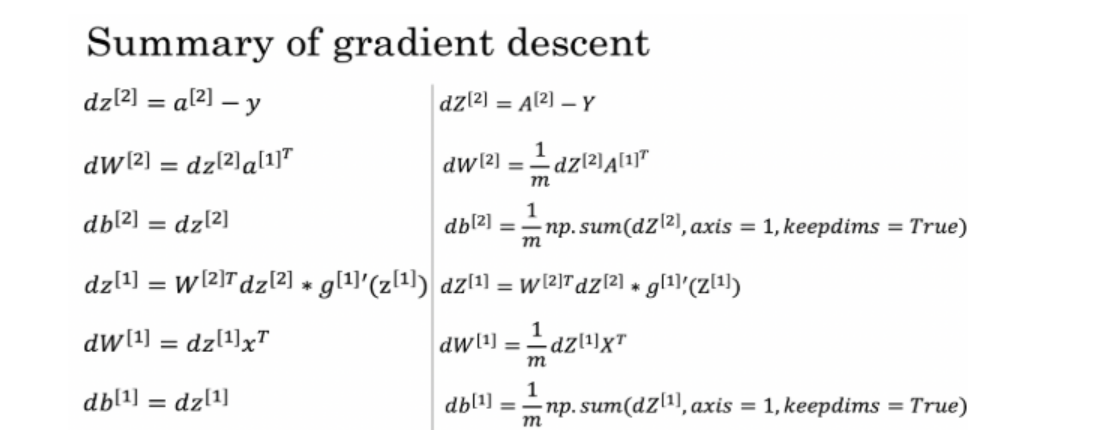

In [12]:
#Implement back_propagation
def backward_propagation(parameters, cache, X, Y):
    m = X.shape[1] #number of samples
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    A1 = cache["A1"]
    A2 = cache["A2"]
    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis = 1, keepdims=True)/m
    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1, 2)))
    dW1 = np.dot(dZ1, X.T)/m
    db1 = np.sum(dZ1, axis=1, keepdims=True)/m
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [13]:
# Implement the update rule
def update_parameters(parameters, grads, learning_rate = 1.2):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    
    W1 = W1 - learning_rate * dW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * dW2
    b2 = b2 - learning_rate * db2
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [14]:
#Build the neural network model in nn_model()
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    np.random.seed(3)
    n_x = layer_size(X, Y)[0]
    n_y = layer_size(X, Y)[2]
    parameters = initialize_parameters(n_x, n_h, n_y)
    for i in range(0, num_iterations):

        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads)
        
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [15]:
#Implement Predict
def predict(parameters, X):
    A2, cache = forward_propagation(X, parameters)
    predictions = A2 > .5
    return predictions

Cost after iteration 0: 0.693162
Cost after iteration 1000: 0.258625
Cost after iteration 2000: 0.239334
Cost after iteration 3000: 0.230802
Cost after iteration 4000: 0.225528
Cost after iteration 5000: 0.221845
Cost after iteration 6000: 0.219094
Cost after iteration 7000: 0.220628
Cost after iteration 8000: 0.219415
Cost after iteration 9000: 0.218527


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

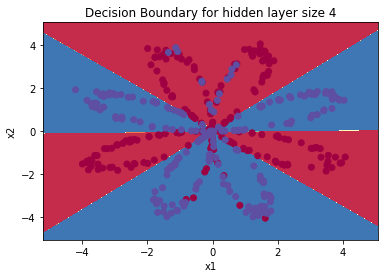

In [16]:
 #Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
plt.title("Decision Boundary for hidden layer size " + str(4))

In [17]:
# Print accuracy
predictions = predict(parameters, X)
accuracy =metrics.accuracy_score(Y[0],predictions[0])
print("Accuracy is:", accuracy)
#print ('Accuracy: %d' % float((np.dot(Y,predictions.T) + np.dot(1-Y,1-predictions.T))/float(Y.size)*100) + '%')

Accuracy is: 0.905


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.5 %
Accuracy for 5 hidden units: 91.25 %
Accuracy for 20 hidden units: 91.0 %
Accuracy for 50 hidden units: 90.25 %


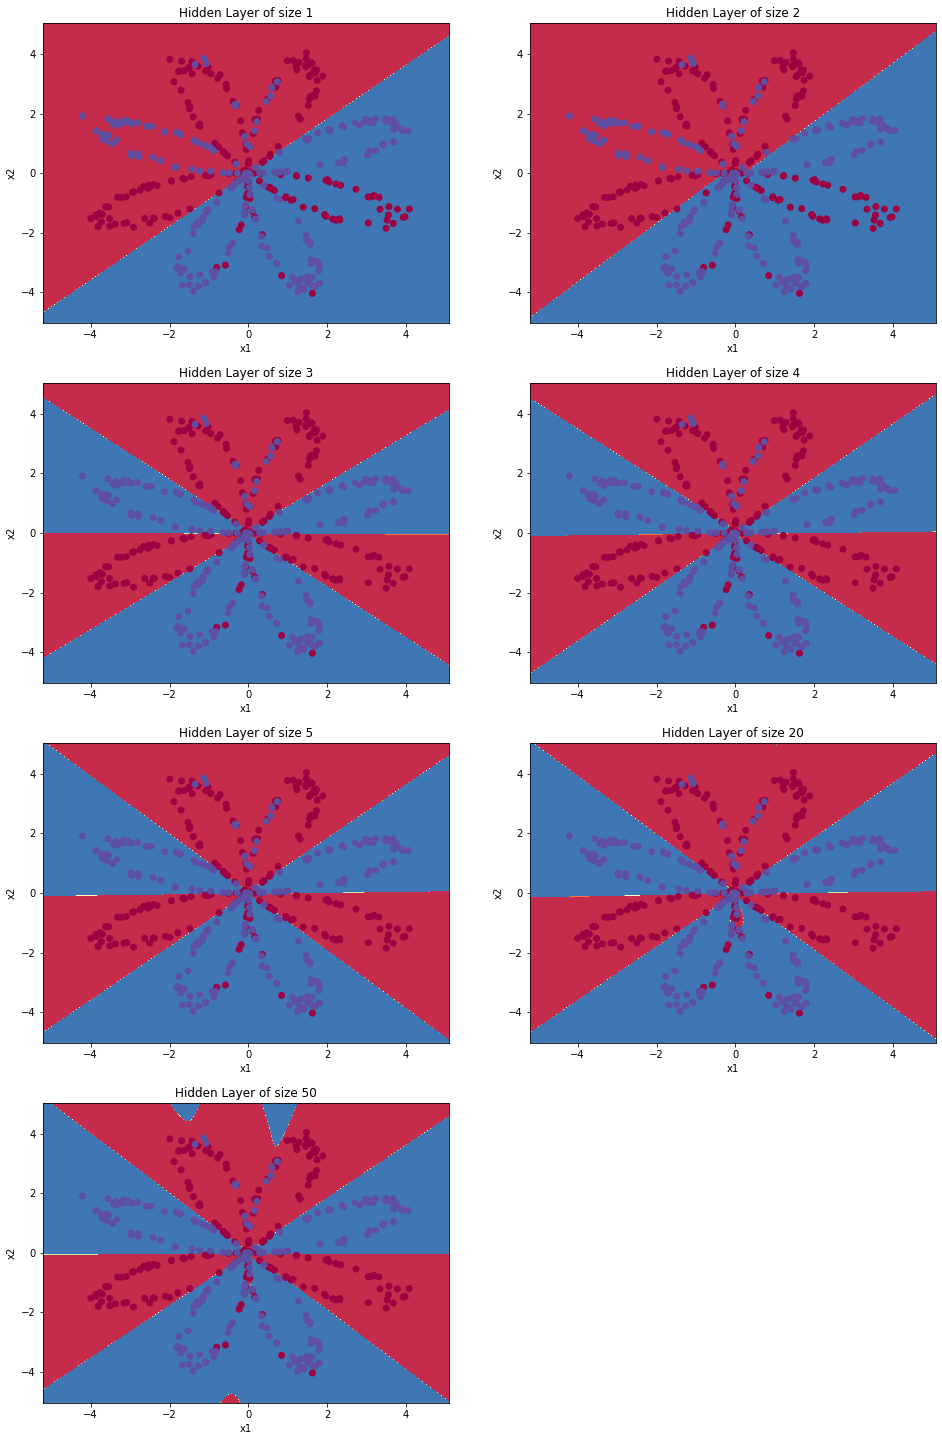

In [18]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y[0])
    predictions = predict(parameters, X)
    accuracy = metrics.accuracy_score(Y[0],predictions[0])
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy*100))